Gamma correction cancelled : Image already bright


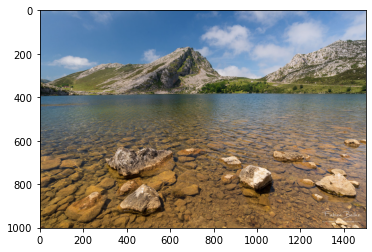

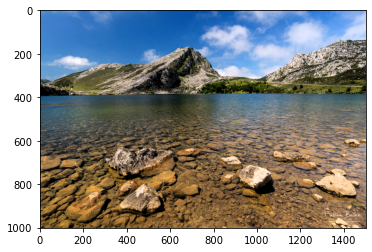

In [30]:
"""
Last name : TROUILLEZ
First name : Franck
Matricule : 000459766
Last update : 02/12/2020 14:47
"""

from skimage.filters.rank import median
from skimage.io import imread, imshow, imsave
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2hsv, hsv2rgb
%matplotlib inline

#############
### INPUT ###
#############

SOURCE_IMAGE = "playa.jpg" #source image

SAVE_IMAGE = True #set to True to save the image
OUTPUT_IMAGE = "enhanced_"+SOURCE_IMAGE #name of the enhanced image


##################
### PARAMETERS ###
##################

#NOISE

USE_NOISE_FILTER = False #set to True if the image is noisy

FILTER_RADIUS = 3 #radius of the mean filter to remove noise

#CONTRAST

#Choose which feature to use (leave it for default values)
USE_GAMMA_CORRECTION = True
USE_AUTOLEVEL = True
USE_EQUALIZATION = False

GAMMA_PARAMETER = None #automatic gamma parameter. Can be set manually by changing the "None" value to the gamma parameter wanted
GAMMA_THRESHOLD = 45 #Value above which gamma correction does not apply

AUTOLEVEL_LOW_THRESHOLD = 0.02 #Threshold for the autolevel. Correspond to the low threshold
AUTOLEVEL_HIGH_THRESHOLD = 0.98 #Threshold for the autolevel. Correspond to the high threshold


#SATURATION

#Choose which feature to use (leave it for default values)
USE_VIBRANCE = True #if saturation used, dont use vibrance
USE_SATURATION = False #if vibrance used, dont use saturation

SATURATION_FACTOR = 1.4 #Factor of saturation increasing
VIBRANCE_THRESHOLD = 0.8   # Implementing the vibrance aspect : Saturate only if saturation value below this threshold to saturate dull colors only

#############################
### FUNCTIONS DEFINITIONS ###
#############################

def checkParams():
    """
    Check the parameters before executing the code. Return a boolean which is true if all the parameters are correct.
    """
    result = True
    if FILTER_RADIUS < 0:
        result = False
        print("Filter radius is a distance and should be positive. Expected : > 0. Given : %s." %(FILTER_RADIUS))
    if GAMMA_THRESHOLD > 255 or GAMMA_THRESHOLD < 0 :
        result = False
        print("Gamma correction threshold value not well defined. Expected : between 0 and 255. Given : %s." %(GAMMA_CORRECTION))
    if AUTOLEVEL_LOW_THRESHOLD > AUTOLEVEL_HIGH_THRESHOLD or AUTOLEVEL_LOW_THRESHOLD < 0 or AUTOLEVEL_HIGH_THRESHOLD > 1:
        result = False
        print("Autolevel percentiles values not well defined. Expected : low < high and between 0 and 1. Given : low : %s, high : %s." %(AUTOLEVEL_LOW_THRESHOLD, AUTOLEVEL_HIGH_THRESHOLD))
    if USE_VIBRANCE and USE_SATURATION :
        result = False
        print("Saturation and vibrance can not be applied at the same time. Choose between one of them.")
    if SATURATION_FACTOR < 0:
        result = False
        print("Saturation factor must be positive. Expected : > 0. Given : %s." %(SATURATION_FACTOR))
    if VIBRANCE_THRESHOLD > 1 or VIBRANCE_THRESHOLD < 0:
        result = False
        print("Vibrance threshold not well defined. Expected : between 0 and 1. Given : %s." %(VIBRANCE_THRESHOLD))
    return result


def noiseReduction(image, radius = FILTER_RADIUS):
    """
    Reduce noise on an image using a median filter. Return a filtered image based on an input image and a radius for the structuring element
    """
    new_image = image.copy()
    new_image[:,:,0] = median(image[:,:,0],disk(radius))
    new_image[:,:,1] = median(image[:,:,1],disk(radius))
    new_image[:,:,2] = median(image[:,:,2],disk(radius))
    return new_image


def cumulHist(im):
    """
    Return the cumulated histogram of a 1 channel picture
    """
    cumul_hist = np.zeros((256,))
    c = 0
    for v in range(256):
        c += (im==v).sum()
        cumul_hist[v] = c
    cumul_hist /= cumul_hist.max()
    return cumul_hist


def autoLevel(image): 
    """
    Return an autoleveled RGB image based on a RGB image.
    """
    hsv_image = rgb2hsv(image)
    v_channel = (hsv_image[:,:,2].copy()*255).astype(np.uint8)
    cumul_hist = cumulHist(v_channel)
    for v in range(256):
        if (cumul_hist[v] > AUTOLEVEL_LOW_THRESHOLD) :
            break;
    gmin = max(0,v-1)
    for v in range(256):
        if (cumul_hist[255-v] < AUTOLEVEL_HIGH_THRESHOLD) :
            break;
    gmax = min(255-v+1, 255)
    lut = np.array([0 for i in range(gmin)]+[255*(gin-gmin)/(gmax-gmin) for gin in range(gmin, gmax)]+[255 for j in range(gmax, 256)])
    v_channel = lut[v_channel]/255
    hsv_image[:,:,2] = v_channel
    new_image = (hsv2rgb(hsv_image)*255).astype(np.uint8)
    return new_image


def equalization(image):
    """
    Return an equalized RGB image based on a RGB image
    """
    hsv_image = rgb2hsv(image)
    v_channel = (hsv_image[:,:,2].copy()*255).astype(np.uint8)
    cumul_hist = cumulHist(v_channel)
    lut = (cumul_hist*255).astype(np.uint8)
    v_channel = lut[v_channel]/255
    hsv_image[:,:,2] = v_channel
    new_image = (hsv2rgb(hsv_image)*255).astype(np.uint8)
    return new_image


def gammaCorrection(image, gamma = None):
    """
    Apply a gamma correction on a RGB image. (If image to bright, does not apply the effect)
    """
    if (gamma == None):
        grey = getValueMedian(image)
        gamma = grey/GAMMA_THRESHOLD
        if (gamma > 1):
            print("Gamma correction cancelled : Image already bright")
            return image
    hsv_image = rgb2hsv(image)
    v_channel = (hsv_image[:,:,2].copy()*255).astype(np.uint8)
    A = 255**(1-gamma)
    lut = np.array([A*gin**gamma for gin in range(256)])
    v_channel = lut[v_channel]/255
    hsv_image[:,:,2] = v_channel
    new_image = (hsv2rgb(hsv_image)*255).astype(np.uint8)
    return new_image


def getValueMedian(image):
    """
    Method called to get the brigthness median of an RGB image
    """
    #It takes the median of the value channel of the HSV image
    return np.median(hsv2rgb(image)[:,:,2]*255)


def increaseSaturation(image):
    """
    Return a version where the saturation of the image given in inputhas increased 
    """
    hsv_image = rgb2hsv(image)
    hsv_image[:,:,1] = np.clip(SATURATION_FACTOR*hsv_image[:,:,1],0,1)
    new_image = (hsv2rgb(hsv_image)*255).astype(np.uint8)
    return new_image


def increaseVibrance(image):
    """
    Return a version where the vibrance of the image given in input has increased
    """
    # The red value should not be the maximum in the 3 RGB channels
    mask1 = (image[:,:,0] < image[:,:,1])
    mask2 = (image[:,:,0] < image[:,:,2])
    mask3 = (mask1 == 1) | (mask2 == 1)
    hsv_image = rgb2hsv(image)
    # The saturation should be low enough
    mask4 = hsv_image[:,:,1] <= VIBRANCE_THRESHOLD
    mask = (mask3 == 1) & (mask4 == 1)
    hsv_image[:,:,1][mask] = np.clip(SATURATION_FACTOR*hsv_image[:,:,1][mask],0,1)
    new_image = (hsv2rgb(hsv_image)*255).astype(np.uint8)
    return new_image


def enhance(image):
    """
    Return an enhanced version of the image given in input
    """
    new_image = image
    if (USE_NOISE_FILTER):
        new_image = noiseReduction(new_image)
    if (USE_AUTOLEVEL):
        new_image = autoLevel(new_image)
    if (USE_EQUALIZATION):
        new_image = equalization(new_image)
    if (USE_GAMMA_CORRECTION):
        new_image = gammaCorrection(new_image, GAMMA_PARAMETER)
    if (USE_SATURATION):
        new_image = increaseSaturation(new_image)
    if (USE_VIBRANCE):
        new_image = increaseVibrance(new_image)
    return new_image

      
        
######################
### MAIN EXECUTION ###
######################

if checkParams():
    #Source image
    imageToEnhance = imread(SOURCE_IMAGE)

    #Image enhanced
    imageEnhanced = enhance(imageToEnhance)

    #Show images
    plt.figure()
    plt.imshow(imageToEnhance)
    plt.show()

    plt.figure()
    plt.imshow(imageEnhanced)
    plt.show()

    #Save the enhanced image
    if SAVE_IMAGE:
        imsave(OUTPUT_IMAGE, imageEnhanced)

